# Using K_means algorithm to recognise color in image

This  Jupyter notebook "k_mean primary color.ipynb" is designed to perform color analysis on a set of images. 
It uses the k-means clustering algorithm to identify the primary colors in each image. 

The colors are then compared to a predefined set of colors (white, pink, red, green, blue, and yellow) using the CIE76 color difference formula, which measures the difference between two colors in the Lab* color space. 

The images are then displayed in a grid, with each image positioned according to its most dominant color. 

This notebook provides a useful tool for understanding the color composition of a collection of images.

## Import libraries

Necessary libraries. They are :
- `sklearn` for KMeans algorithm, 
- `matplotlib.pyplot` for plotting graphs, 
- `numpy` to work with arrays, 
- `cv2` to work with image data, 
- `collections` to use Counter to count values, 
- `rgb2lab` to convert RGB values and 
- `deltaE_cie76` to calculate similarity between colors.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

## Load the image 

Import one image in jpg form

The type of this input is <class 'numpy.ndarray'>
Shape: (100, 100, 3)


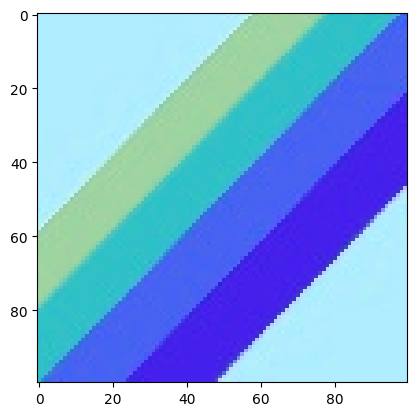

In [2]:
image = cv2.imread('images_jpg\\colors.jpg')
if image is None:
    print("Failed to load image")
else:
    print("The type of this input is {}".format(type(image)))
    print("Shape: {}".format(image.shape))
    plt.imshow(image)

### Note
The image appears to have altered colors when compared to the original. This discrepancy arises because OpenCV, by default, processes images in the BLUE GREEN RED (BGR) color sequence. Therefore, we need to adjust this to the RED GREEN BLUE (RGB) sequence to maintain the original color representation.

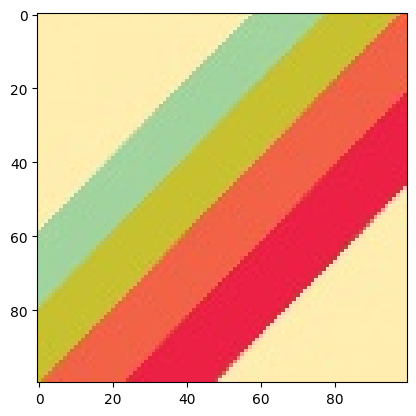

In [3]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Note
In cases where we are dealing with large images or multiple images of varying dimensions, it may be beneficial to resize the images to a consistent size.

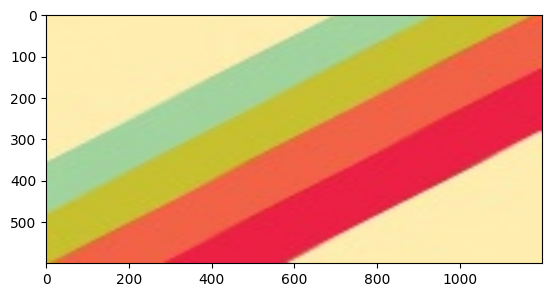

In [4]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

## Color Identification (1 primary color)

I use this function in order to take the `hex` values of the colors that I will identify.

In [5]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def load_image(image_path) : reads an image from the provided path and converts it from BGR -> RGB color space

In [6]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Note
I will plot the data points in 3D space using python matplotlib in order to see the pixels how they are in the space

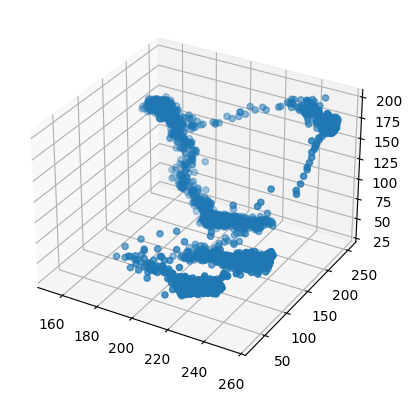

In [7]:
%matplotlib inline

#get rgb values from image to 1D array
r, g, b = cv2.split(image)
r = r.flatten()
g = g.flatten()
b = b.flatten()

#plotting 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(r, g, b)
plt.show()

### Run Kmean algorithm using number of clusters according to the number of dominant colors that we want ( 1st option)
#### extract_colors(image, number_of_colors, show_chart): does the main work of color extraction.

In [20]:
def extract_colors(image, number_of_colors, show_chart):
    
    # resize the image to speed up processing time
    #interpolation is a metod to reduce the size of the image while keeping the quality good
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    # change the shape of the image, before it was 3D array(height, width, color channels), now it is 2D array(number of pixels, color channels)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    # create the model
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image) # fit the model to the image data and predicts the cluster for each pixel
    # more specifcally, if we have 3 clusters, the labels will be 0, 1, 2, and each pixel will be assigned to one of these clusters, so if a particular pixel has label 0, it means it belongs to the first cluster
    
    counts = Counter(labels) # counts the number of pixels in each cluster
    counts = dict(sorted(counts.items())) # sort to ensure correct color percentage
    
    # get the cluster centers
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()] # orders the colors according to the sorted keys of the counts dictionary
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()] # converts the RGB colors to HEX
    rgb_colors = [ordered_colors[i] for i in counts.keys()] # gets the RGB colors

    # show the chart
    if (show_chart):
        plt.figure(figsize = (8, 6)) # set the size of the chart
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors) # create the pie chart
    
    return rgb_colors ,labels

### Call the function with the number of dominant colors that you want to appeared

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([array([253.92475884, 236.70418006, 175.82797428]),
  array([240.21839646,  99.09837678,  69.86866699]),
  array([199.96876712, 191.1709589 ,  50.83342466]),
  array([163.52706553, 210.8974359 , 154.95156695]),
  array([233.23280098,  33.57739558,  67.39189189])],
 array([0, 0, 0, ..., 0, 0, 0]))

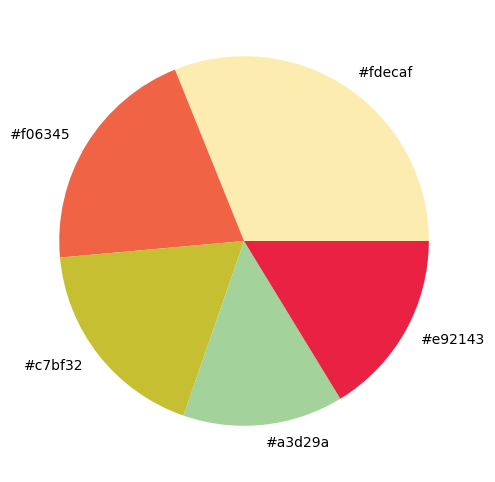

In [21]:
extract_colors(load_image('images_jpg\\colors.jpg'), 5, True)

### Run Kmean algorithm using the Elbow method to find the number of clusters ( 2nd option)
#### extract_colors_elbow(image, show_chart):

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from kneed import KneeLocator
import numpy as np

def extract_colors_elbow(image, show_chart):
    # resize and reshape the image as before
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

    # use the elbow method to find the optimal number of clusters
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(modified_image)
        distortions.append(kmeanModel.inertia_)

    # plot the elbow
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # find the elbow point
    kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    number_of_colors = kn.knee

    # create the model with the optimal number of clusters
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)
    counts = dict(sorted(counts.items()))

    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    return rgb_colors ,labels

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

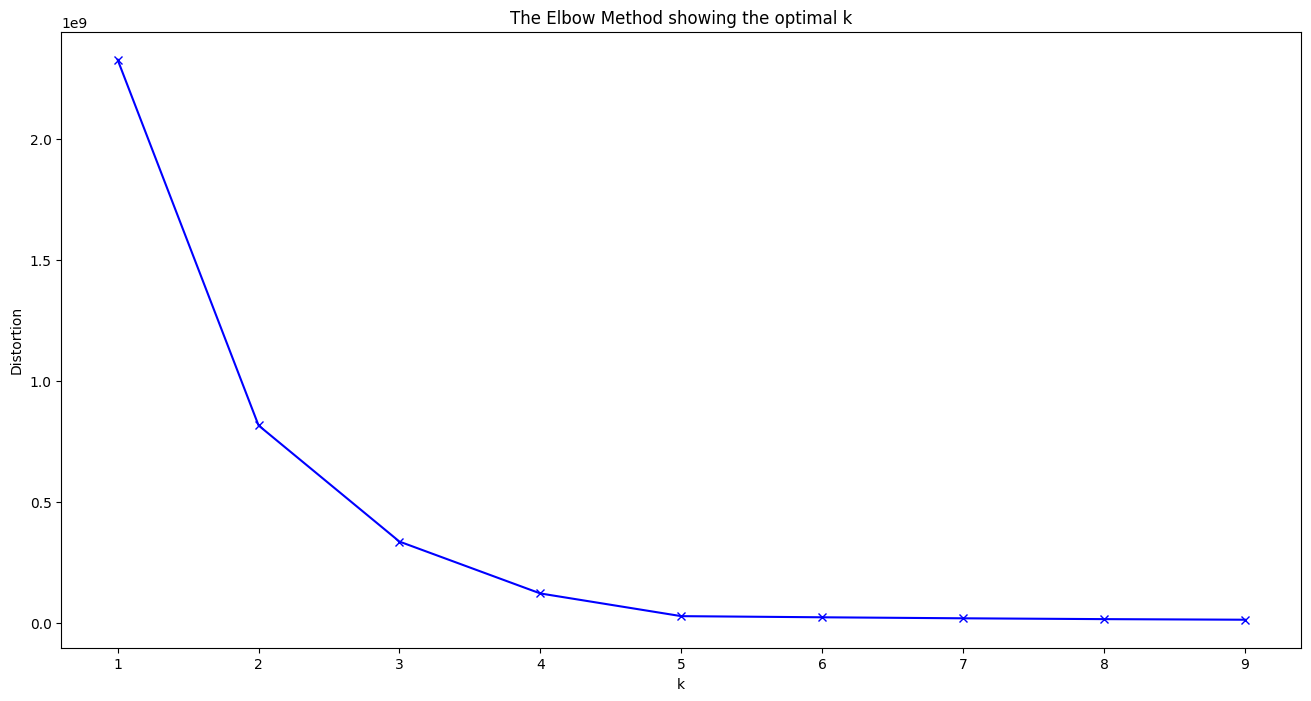

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([array([226.11742424, 228.76782531, 169.6847148 ]),
  array([237.24127508,  69.57653201,  68.8224787 ]),
  array([199.77148959, 190.80032034,  51.74319274])],
 array([0, 0, 0, ..., 0, 0, 0]))

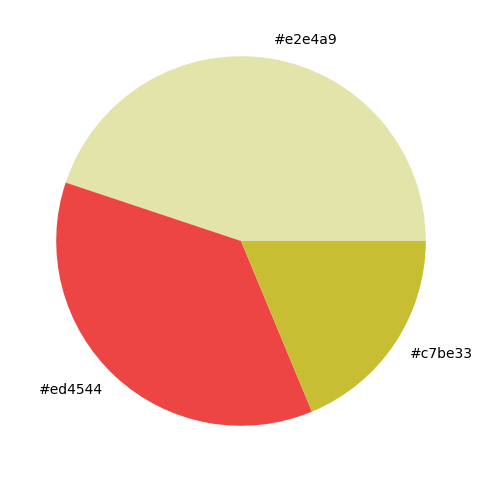

In [25]:
extract_colors_elbow(load_image('images_jpg\\colors.jpg'), True)

### Compare the two options 

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

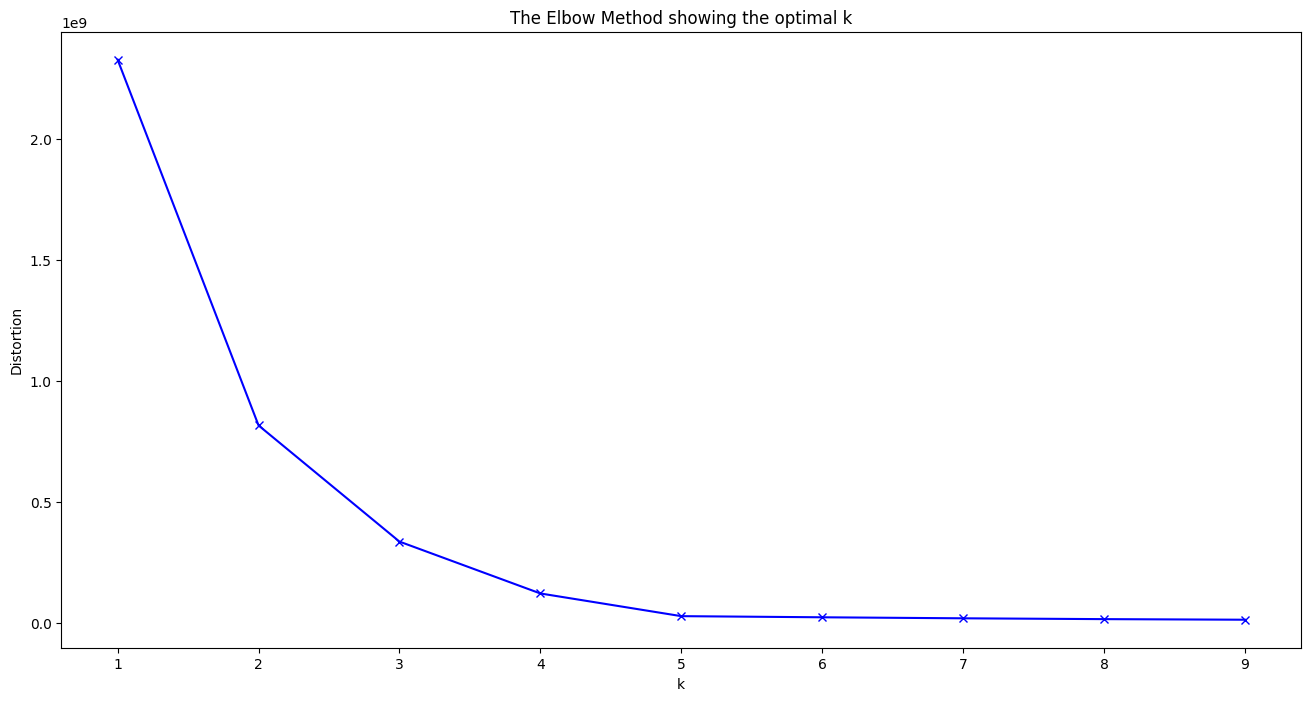

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


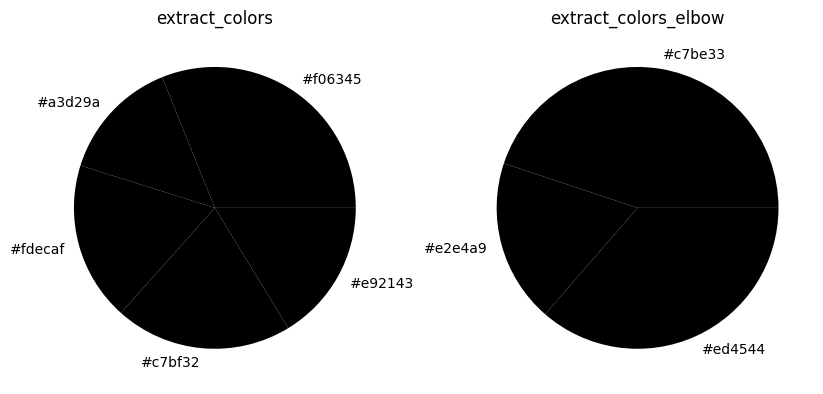

In [28]:
def compare_colors(image):
    # Extract colors using both methods
    colors1, labels1 = extract_colors(image, 5, False)
    colors2, labels2 = extract_colors_elbow(image, False)

    # Count the labels
    counts1 = Counter(labels1)
    counts2 = Counter(labels2)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot pie chart for extract_colors
    axs[0].pie(counts1.values(), labels=[RGB2HEX(color) for color in colors1], colors=[RGB2HEX(color/255) for color in colors1])
    axs[0].set_title('extract_colors')

    # Plot pie chart for extract_colors_elbow
    axs[1].pie(counts2.values(), labels=[RGB2HEX(color) for color in colors2], colors=[RGB2HEX(color/255) for color in colors2])
    axs[1].set_title('extract_colors_elbow')

    # Show the plot
    plt.show()
    
compare_colors(load_image('images_jpg\\colors.jpg'))

### New Plot with the Colors

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


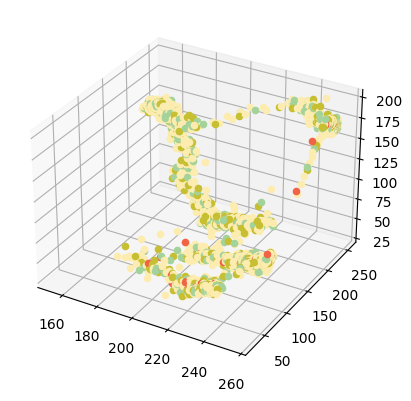

In [10]:
def visualize_clusters(image, labels, colors):
    r, g, b = cv2.split(image)
    r = r.flatten()
    g = g.flatten()
    b = b.flatten()

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for label, pix in zip(labels, zip(r, g, b)):
        ax.scatter(pix[0], pix[1], pix[2], color = RGB2HEX(colors[label]))
    plt.show()

rgb_colors, labels = extract_colors(image, number_of_colors=5, show_chart=False)
visualize_clusters(image, labels, rgb_colors)

### Show which color is most effective 
it means which clusters has the most data points 

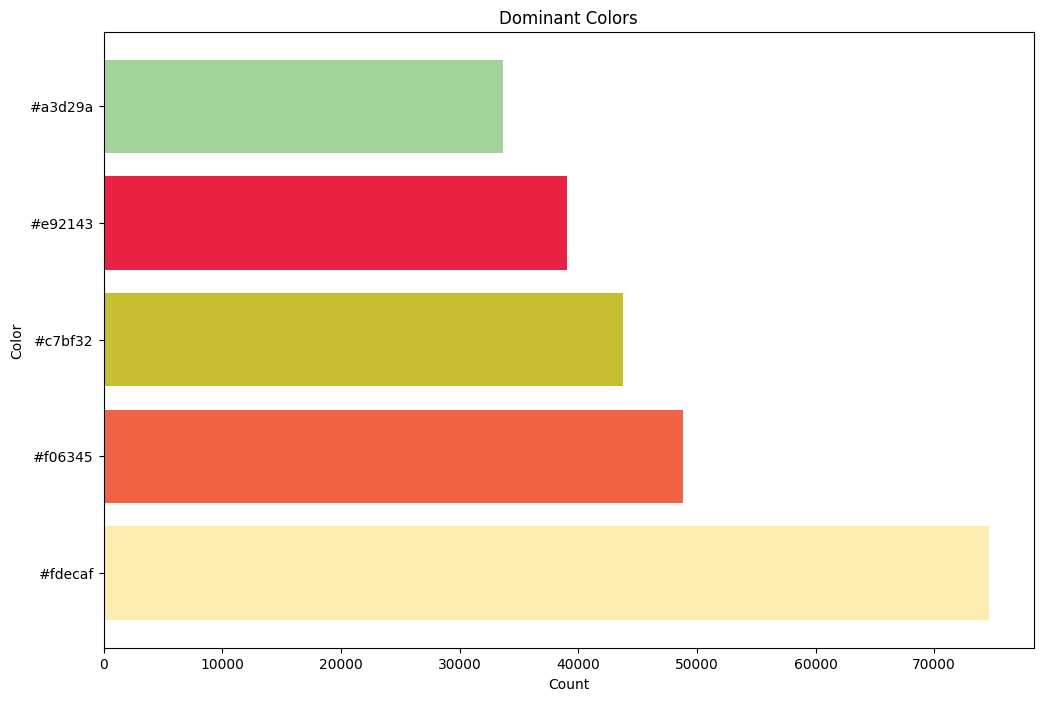

In [11]:
def display_dominant_colors(counts, hex_colors):
    # sort the counts dictionary in descending order
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

    # create lists for colors and their counts
    dominant_colors = [hex_colors[i] for i in sorted_counts.keys()]
    counts = list(sorted_counts.values())

    # create a bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(dominant_colors, counts, color=dominant_colors)
    plt.xlabel('Count')
    plt.ylabel('Color')
    plt.title('Dominant Colors')
    plt.show()
    
# Count labels
counts = Counter(labels)

# Convert RGB colors to HEX
hex_colors = [RGB2HEX(rgb_color) for rgb_color in rgb_colors]

# Display dominant colors
display_dominant_colors(counts, hex_colors)

### Find paints that have some primary color that we choose 
#### Define the necessary functions:

In [12]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]]))) #converts RGB to CIE 1976 L*a*b values. The CIELAB color space 
                                                              #(also known as CIE L*a*b*) is a color space defined by the  
                                                              #International Commission on Illumination (CIE) in 1976.

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color) #Euclidean distance between two points in Lab color space.
        if (diff < threshold):
            select_image = True
    
    return select_image

def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if selected:
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            index += 1
            if index > 5:  # Stop after 5 images
                break

#### Load the path with the gallery of paintings and the the values of the colors that we want to identify:

In [13]:
IMAGE_DIRECTORY = 'C:\Biography\ArtEmotionalPalette-AI\images_jpg'
COLORS = {
    'WHITE' : [255,255,255],
    'PINK': [227,0,235],
    'RED': [255,0,0],
    'GREEN': [0, 128, 0],
    'BLUE': [0, 0, 128],
    'YELLOW': [255, 255, 0]
}
images = []

#to get the list of all files and directories in the specified directory.
for file in os.listdir(IMAGE_DIRECTORY):
    images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))
    
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

NameError: name 'get_image' is not defined

#### Find all the paintings that have the color value : "WHITE"

In [ ]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['WHITE'], 60, 10)

### Metrics 
We use them to evaluate the quality and performance of the algorithm . Below are some of the metrics :

##### CIE76 forlmula 
Delta E is a metric for understanding how the human eye perceives color difference. 

In [ ]:
from skimage import color
import numpy as np

def rgb2lab(inputColor):
    num = 0
    RGB = [0, 0, 0]

    for value in inputColor:
        value = float(value) / 255

        if value > 0.04045:
            value = ((value + 0.055) / 1.055) ** 2.4
        else:
            value = value / 12.92

        RGB[num] = value * 100
        num = num + 1

    XYZ = [0, 0, 0,]

    X = RGB[0] * 0.4124 + RGB[1] * 0.3576 + RGB[2] * 0.1805
    Y = RGB[0] * 0.2126 + RGB[1] * 0.7152 + RGB[2] * 0.0722
    Z = RGB[0] * 0.0193 + RGB[1] * 0.1192 + RGB[2] * 0.9505
    XYZ[0] = round(X, 4)
    XYZ[1] = round(Y, 4)
    XYZ[2] = round(Z, 4)

    XYZ[0] = float(XYZ[0]) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[1] = float(XYZ[1]) / 100.0          # ref_Y = 100.000
    XYZ[2] = float(XYZ[2]) / 108.883        # ref_Z = 108.883

    num = 0
    for value in XYZ:
        if value > 0.008856:
            value = value ** (0.3333333333333333)
        else:
            value = (7.787 * value) + (16 / 116)

        XYZ[num] = value
        num = num + 1

    Lab = [0, 0, 0]

    L = (116 * XYZ[1]) - 16
    a = 500 * (XYZ[0] - XYZ[1])
    b = 200 * (XYZ[1] - XYZ[2])

    Lab [0] = round(L, 4)
    Lab [1] = round(a, 4)
    Lab [2] = round(b, 4)

    return Lab

def delta_e_cie76(lab1, lab2):
    return np.sqrt(np.sum((np.array(lab1) - np.array(lab2)) ** 2))

# Example usage:
color1_rgb = [255, 255, 255]
color2_rgb = [255, 254, 253]

color1_lab = rgb2lab(color1_rgb)
color2_lab = rgb2lab(color2_rgb)

delta_e = delta_e_cie76(color1_lab, color2_lab)
print(delta_e)

0.6807638210128408


## Conclusion

In this notebook, we used KMeans to extract majority colors from images. We then used the RGB Values of Colors to identify images from a collection that have that color in them.